In [177]:
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt
import time
import pickle
import wandb

from transformers import BertConfig, BertTokenizerFast
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from collections import defaultdict, Counter
from models import BertForDiffusion, DiffusionLM, ConditionalDiffusionLM
from data_utils import load_qqp_dataset_and_tokenizer_from_disk, QQPParaphraseDataset, load_split_qqp_dataset_and_tokenizer_from_disk
from noise_schedule import get_named_beta_schedule
from train_utils import train_conditional, evaluate_conditional
from metric_utils import calculate_bleu, calculate_rouge

%matplotlib inline

In [2]:
# dataset args
max_len = 32

# training args
batch_size = 64
device = torch.device("cuda:2")
lr = 1e-4
num_epoch = 30
weight_decay = 0
num_warmup_steps = 100

# model args
word_embedding_dim = 512
# hidden_size = 768
# num_hidden_layers = 12
# num_attention_heads = 12
# intermediate_size = 3072
hidden_size = 512
num_hidden_layers = 4
num_attention_heads = 8
intermediate_size = 2048
max_position_embeddings = max_len

encoder_type = 'from-scratch'

In [3]:
train_dataset, eval_dataset, tokenizer = load_split_qqp_dataset_and_tokenizer_from_disk(data_path="data")

# tokenized_qqp_train, tokenized_qqp_eval, tokenizer = load_qqp_dataset_and_tokenizer_from_disk(data_path="data")

rev_tokenizer = {v: k for k, v in tokenizer.items()}

print("Tokenizer vocab size:", len(tokenizer))

# train_dataset = QQPParaphraseDataset(dataset=tokenized_qqp_train, random_swap=True)
print("Training set size:", len(train_dataset))
# eval_dataset = QQPParaphraseDataset(dataset=tokenized_qqp_eval, random_swap=False)
print("Evaluation set size:", len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

Tokenizer vocab size: 15672
Training set size: 120940
Evaluation set size: 13438


In [4]:
config = BertConfig(vocab_size=len(tokenizer), hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, max_position_embeddings=max_position_embeddings, pad_token_id=tokenizer['[PAD]'])

config.T = 2000
# comment next line if using bit word embedding
config.word_embedding_dim = word_embedding_dim

print(config)

betas = torch.Tensor(get_named_beta_schedule(schedule_name="cosine", num_diffusion_timesteps=config.T))

BertConfig {
  "T": 2000,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 32,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 15672
}



In [5]:
diffusion_model = ConditionalDiffusionLM(
    config=config, 
    betas=betas, 
    use_shared_weight=False, 
    lm_head_bias=True, 
    add_emb_noise=False, 
    conditional_gen=True, 
    encoder_type=encoder_type, 
    encoder_name_or_path='bert-base-uncased', 
    emb_type='learned',
).to(device)

print("Diffusion model #parameters:")
print(sum([p.numel() for p in diffusion_model.parameters()]))

print("Diffusion model #trainable parameters")
print(sum([p.numel() for p in filter(lambda p:p.requires_grad, diffusion_model.parameters())]))

using learned word embedding
set word_embedding_dim to: 512
Diffusion model #parameters:
55452472
Diffusion model #trainable parameters
55452472


In [6]:
optimizer = torch.optim.AdamW(filter(lambda p:p.requires_grad, diffusion_model.parameters()), lr=lr, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epoch*len(train_dataloader))

In [7]:
# train loop
# loss_terms_dict_lst = []
loss_terms_dict = defaultdict(list)
loss_terms_weights = None
verbose = True
print_steps=100
progress_bar = tqdm(range(num_epoch*len(train_dataloader)))

for epoch in range(num_epoch):
    print("epoch:",epoch+1)
    # loss_terms_dict_lst.append(train_conditional(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,progress_bar=progress_bar ,verbose=True))
    device = next(diffusion_model.parameters()).device

    if loss_terms_weights is None:
        loss_terms_weights = {}
        for term_name in diffusion_model.loss_terms:
            loss_terms_weights[term_name] = 1

    training_loss = {}
    for term_name in diffusion_model.loss_terms:
        training_loss[term_name] = 0
    sample_cnt = 0
    diffusion_model.train()
    for step, data in enumerate(train_dataloader):

        if diffusion_model.model.encoder_type in ['frozen', 'fine-tune']:
            # use input_ids and attention mask from bert tokenizer
            # question1 as source, question2 as target
            input_ids = data['question2_input_ids'].to(device)
            attention_mask = data['question2_attention_mask'].to(device)
            src_ids = data['question1_input_ids_bert'].to(device)
            src_attention_mask = data['question1_attention_mask_bert'].to(device)
            loss_terms = diffusion_model(input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            src_ids=src_ids,
                                            src_attention_mask=src_attention_mask)
        elif diffusion_model.model.encoder_type in ['from-scratch']:
            # use input_ids and attention mask from custom tokenizer
            input_ids = data['question2_input_ids'].to(device)
            attention_mask = data['question2_attention_mask'].to(device)
            src_ids = data['question1_input_ids'].to(device)
            src_attention_mask = data['question1_attention_mask'].to(device)
            loss_terms = diffusion_model(input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            src_ids=src_ids,
                                            src_attention_mask=src_attention_mask)
        else:
            raise NotImplementedError

        loss = sum([v.mean()*loss_terms_weights[k] for k, v in loss_terms.items()])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        progress_bar.update(1)

        bs = input_ids.shape[0]
        sample_cnt += bs
        # training_loss += loss.detach().cpu() * bs

        for k, v in loss_terms.items():
            loss_term = (v.detach().cpu().mean()*loss_terms_weights[k]).item()
            loss_terms_dict[k].append(loss_term)
            training_loss[k] += loss_term * bs

        if verbose and step % print_steps == print_steps-1:
            # print training loss
            # training_loss /= sample_cnt
            print('step:', step+1)
            for k, v in training_loss.items():
                print(k, ' training loss={:.5f}'.format(v/sample_cnt))
            sample_cnt = 0
            training_loss = {}
            for term_name in diffusion_model.loss_terms:
                training_loss[term_name] = 0

    # evaluate_conditional(diffusion_model=diffusion_model, dataloader=eval_dataloader,)
    device = next(diffusion_model.parameters()).device

    if loss_terms_weights is None:
        loss_terms_weights = {}
        for term_name in diffusion_model.loss_terms:
            loss_terms_weights[term_name] = 1

    print("Evaluating...")
    diffusion_model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in eval_dataloader:
            
            if diffusion_model.model.encoder_type in ['frozen', 'fine-tune']:
                # use input_ids and attention mask from bert tokenizer
                # question1 as source, question2 as target
                input_ids = data['question2_input_ids'].to(device)
                attention_mask = data['question2_attention_mask'].to(device)
                src_ids = data['question1_input_ids_bert'].to(device)
                src_attention_mask = data['question1_attention_mask_bert'].to(device)
                loss_terms = diffusion_model(input_ids=input_ids,
                                             attention_mask=attention_mask,
                                             src_ids=src_ids,
                                             src_attention_mask=src_attention_mask)
            elif diffusion_model.model.encoder_type in ['from-scratch']:
                # use input_ids and attention mask from custom tokenizer
                input_ids = data['question2_input_ids'].to(device)
                attention_mask = data['question2_attention_mask'].to(device)
                src_ids = data['question1_input_ids'].to(device)
                src_attention_mask = data['question1_attention_mask'].to(device)
                loss_terms = diffusion_model(input_ids=input_ids,
                                             attention_mask=attention_mask,
                                             src_ids=src_ids,
                                             src_attention_mask=src_attention_mask)
            else:
                raise NotImplementedError

            loss = sum([v.mean()*loss_terms_weights[k] for k, v in loss_terms.items()])
            bs = input_ids.shape[0]
            test_loss += bs*loss

        test_loss /= len(eval_dataloader.dataset)
        if verbose:
            print('eval loss={:.5f}'.format(test_loss))


  0%|          | 0/56700 [00:00<?, ?it/s]

epoch: 1
step: 100
mse  training loss=0.70365
L_T  training loss=0.00000
rounding  training loss=8.94612
step: 200
mse  training loss=0.35716
L_T  training loss=0.00000
rounding  training loss=4.37584
step: 300
mse  training loss=0.30703
L_T  training loss=0.00000
rounding  training loss=1.74582
step: 400
mse  training loss=0.28241
L_T  training loss=0.00000
rounding  training loss=1.02338
step: 500
mse  training loss=0.26434
L_T  training loss=0.00000
rounding  training loss=0.76507
step: 600
mse  training loss=0.24443
L_T  training loss=0.00000
rounding  training loss=0.60915
step: 700
mse  training loss=0.23552
L_T  training loss=0.00000
rounding  training loss=0.51759
step: 800
mse  training loss=0.22217
L_T  training loss=0.00000
rounding  training loss=0.44281
step: 900
mse  training loss=0.21193
L_T  training loss=0.00000
rounding  training loss=0.38758
step: 1000
mse  training loss=0.20430
L_T  training loss=0.00000
rounding  training loss=0.33558
step: 1100
mse  training loss=

Text(0, 0.5, 'Loss')

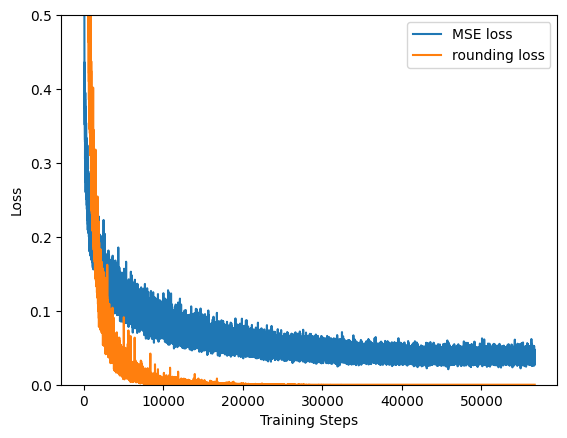

In [176]:
plt.plot(loss_terms_dict['mse'], label='MSE loss')
plt.plot(loss_terms_dict['rounding'], label='rounding loss')
plt.ylim((0, 0.5))
# plt.yscale('log')
plt.legend()
plt.xlabel("Training Steps")
plt.ylabel("Loss")

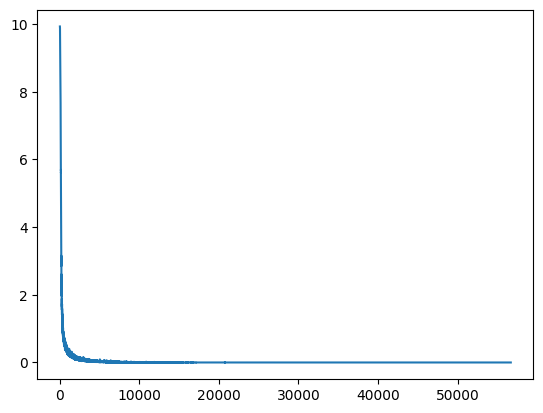

In [9]:
plt.plot(loss_terms_dict['rounding'])

In [22]:
trained_ts = diffusion_model.word_embeddings.weight.data.cpu()
init_ts = torch.nn.Embedding(len(tokenizer), diffusion_model.config.word_embedding_dim).weight.data

trained_ts_normed = trained_ts / trained_ts.norm(dim=1, keepdim=True)
init_ts_normed = init_ts / init_ts.norm(dim=1, keepdim=True)

trained_cosine = torch.matmul(trained_ts_normed, trained_ts_normed.T)
init_cosine = torch.matmul(init_ts_normed, init_ts_normed.T)

In [32]:
trained_ts.norm(dim=1)[:100]

tensor([21.8831,  8.6172,  7.3387, 12.2852, 10.4657,  7.9724,  9.0047, 15.2567,
         9.5580, 20.4276, 14.9555,  6.4496, 10.2263,  8.5789, 13.5854, 13.6579,
        15.6314,  6.8749,  5.3842,  9.2093, 13.7879, 13.1452, 14.2123,  9.4225,
        11.6611, 13.5092, 12.5825, 13.5993, 10.4602, 14.2846, 11.3724, 13.2142,
        11.8243, 11.0697, 14.4086, 13.6377, 12.2509, 15.3699, 15.6723, 11.4584,
        12.9936, 14.6573, 15.7526, 13.5041, 13.3888,  6.9546, 14.8483,  8.8226,
        16.3888, 19.2825, 11.0580, 14.4109,  8.9228, 18.8372, 13.4110, 14.6643,
         7.4504, 16.8032, 14.2178, 18.4082, 13.6273, 13.5975, 14.5907, 13.9242,
        11.4729,  9.8927, 14.1217, 13.4206, 13.6141, 11.9385, 15.9566, 12.3583,
        15.4035, 13.1177, 19.6243, 12.5618, 15.1814, 12.5672,  9.8864, 22.4683,
        12.5661, 12.3967, 14.8720, 18.3632, 14.4745, 15.0497, 15.1815, 15.6543,
        13.5556, 13.7822,  7.7458, 15.7502, 12.6514, 14.3874,  6.4917, 17.2969,
        12.1216, 14.3382, 14.8450, 10.98

In [55]:
cnter = Counter()
for d in train_dataset:
    cnter.update(d['question1_input_ids'].tolist())
    cnter.update(d['question2_input_ids'].tolist())

(0.0, 1000.0)

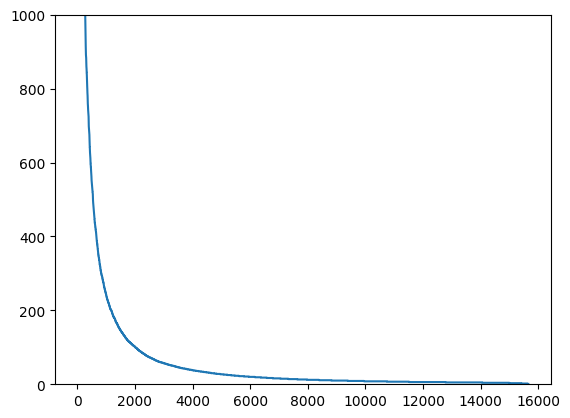

In [93]:
plt.plot(sorted(cnter.values(), reverse=True))
plt.ylim(0, 1000)

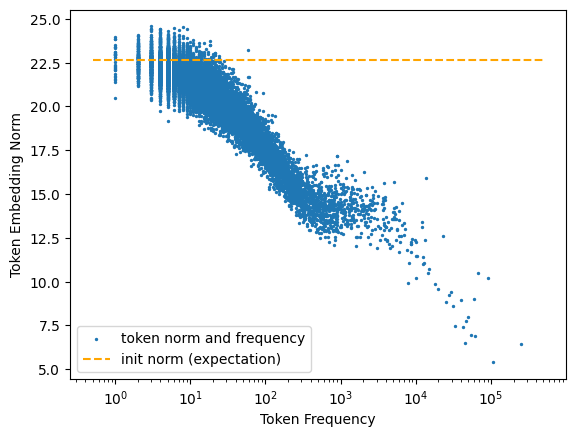

In [168]:
# plt.figure()
x, y = [], []
for id in cnter:
    if id > 3:  # skip special tokens
        x.append(cnter[id])
        y.append(trained_ts[id].norm().item())
    # x.append(cnter[id])
    # y.append(trained_ts[id].norm().item())
plt.scatter(x, y, s = 2, label='token norm and frequency')
plt.xscale('log')

plt.plot([0.5, 5 * 10**5], [512**0.5] * 2, color='orange', linestyle='--', label='init norm (expectation)')

# plt.xlim(0, 6 * 10 ** 5)

plt.xlabel('Token Frequency')
plt.ylabel('Token Embedding Norm')

plt.legend()
plt.savefig('figs/token_emb_norm.png')

In [81]:
norm_lt10, norm_gt10 = [], []
for id in cnter:
    if cnter[id] <= 10:
        norm_lt10.append(trained_ts[id].norm().item())
    else:
        norm_gt10.append(trained_ts[id].norm().item())

In [83]:
print(sum(norm_lt10) / len(norm_lt10))
print(sum(norm_gt10) / len(norm_gt10))

21.99037030510038
19.115726714582348


In [161]:
id_gt10 = [id for id in cnter if cnter[id] >= 100 and id > 3]
embs = [trained_ts[id] for id in id_gt10]
print(len(embs))

2016


In [166]:
N = len(embs)
trained_dist, init_dist = 0, 0
for i in tqdm(range(N)):
    for j in range(i+1, N):
        trained_dist += (embs[i] - embs[j]).norm()
        init_dist += (init_ts[i] - init_ts[j]).norm()

  0%|          | 0/2016 [00:00<?, ?it/s]

In [167]:
print(trained_dist / (N * (N-1) / 2))
print(init_dist / (N * (N-1) / 2))

tensor(21.9763)
tensor(31.9728)


In [43]:
print(trained_ts.norm(dim=1).mean())
print(init_ts.norm(dim=1).mean())

tensor(20.3728)
tensor(22.6171)


In [23]:
V = len(tokenizer)
(trained_cosine.sum() - V) / (V * (V - 1))

tensor(3.0555e-05)

In [24]:
(init_cosine.sum() - V) / (V * (V - 1))

tensor(-1.0726e-07)

In [ ]:
torch.save(diffusion_model.state_dict(), "checkpoints/conditional_from_scratch.pth")

In [6]:
# diffusion_model.load_state_dict(torch.load("checkpoints/20221015_2026"))
diffusion_model.load_state_dict(torch.load("checkpoints/20220906_0519"), strict=False)

_IncompatibleKeys(missing_keys=['alphas_bar', 'alphas_bar_prev'], unexpected_keys=[])

In [7]:
evaluate_conditional(diffusion_model=diffusion_model, dataloader=eval_dataloader,)

  0%|          | 0/210 [00:00<?, ?it/s]

eval loss=0.07535


tensor(0.0753, device='cuda:1')

In [34]:
diffusion_model.eval()

generated_questions_mbr5_ddim20 = diffusion_model.generate(
    dataset = eval_dataset,
    rev_tokenizer=rev_tokenizer,
    sampling_timesteps=20,
    eta=0,
    mbr=5,
    verbose=True,
)

  0%|          | 0/105 [00:00<?, ?it/s]

/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

In [35]:
bleu_dict = calculate_bleu(generated_questions_mbr5_ddim20, eval_dataset, rev_tokenizer)
print(sum(bleu_dict["bleu"])/len(bleu_dict["bleu"]))
print(sum(bleu_dict["self_bleu"])/len(bleu_dict["self_bleu"]))

0.15155854506376149
0.22320761914790413


In [36]:
rouge_scores = calculate_rouge(generated_questions_mbr5_ddim20, eval_dataset, rev_tokenizer)
rouge_l_f = [d['rouge-l']['f'] for d in rouge_scores]
print(sum(rouge_l_f)/len(rouge_l_f))

0.5461694549349757


In [33]:
i = 51
src_question = [rev_tokenizer[id.item()] for id in eval_dataset[i]['question1_input_ids']]
src_question = list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], src_question))
print(" ".join(src_question))

tgt_question = [rev_tokenizer[id.item()] for id in eval_dataset[i]['question2_input_ids']]
tgt_question = list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], tgt_question))
print(" ".join(tgt_question))

#print(" ".join(generated_questions_mbr1_ddim200[i]))
print(" ".join(generated_questions_mbr15_ddim2[i]))
#print(" ".join(generated_questions_mbr5_ddim20[i]))

What are some ways to help a teenager overcome depression ?
How does anyone overcome depression ?
How do I overcome depression ?


In [7]:
diffusion_model.eval()

generated_questions_mbr5 = diffusion_model.generate(
    dataset = eval_dataset,
    rev_tokenizer=rev_tokenizer,
    sampling_timesteps=200,
    eta=0,
    mbr=5,
    verbose=True,
)

  0%|          | 0/105 [00:00<?, ?it/s]

/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

In [9]:
bleu_dict = calculate_bleu(generated_questions_mbr5, eval_dataset, rev_tokenizer)
print(sum(bleu_dict["bleu"])/len(bleu_dict["bleu"]))
print(sum(bleu_dict["self_bleu"])/len(bleu_dict["self_bleu"]))

/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

0.18039911311842954
0.2751321938279151


In [10]:
rouge_scores = calculate_rouge(generated_questions_mbr5, eval_dataset, rev_tokenizer)
rouge_l_f = [d['rouge-l']['f'] for d in rouge_scores]
print(sum(rouge_l_f)/len(rouge_l_f))

0.5874787212343898


In [13]:
eval_batch = next(iter(eval_dataloader))

In [14]:
from nltk.translate.bleu_score import sentence_bleu

In [22]:
generated_questions = []
bs = eval_batch['question1_input_ids'].shape[0]
mbr = 5
if mbr > 1:     # using MBR decoding
    batch_questions = []
    for cnt in range(mbr):
        x_T = torch.randn(size=(bs,
                                diffusion_model.config.max_position_embeddings,
                                diffusion_model.config.word_embedding_dim))
        final_hidden_state = diffusion_model.ddim_sample(x_T.to(device),
                                              sampling_timesteps=200,
                                              eta=0,
                                              src_ids=eval_batch['question1_input_ids'].to(device),
                                              src_attention_mask=eval_batch['question1_attention_mask'].to(device),
                                              return_hidden_states=False,
                                              verbose=False
                                              )
        sampled_ids = diffusion_model.rounding(final_hidden_state).cpu()
        questions = [[rev_tokenizer[token_id.item()] for token_id in sampled_id] for sampled_id in sampled_ids]
        batch_questions.append([list(filter(lambda x: x not in ['[PAD]', '[START]', '[END]'], question)) for question in questions])
    # batch_questions [mbr, bs, question]
    for batch_ind in range(bs):
        candidates = [one_generation[batch_ind] for one_generation in batch_questions]      # [mbr, question]
        bleu_scores = torch.zeros(mbr)
        for candidate_ind, candidate in enumerate(candidates):
            for ref_ind, ref in enumerate(candidates):
                if ref_ind != candidate_ind:
                    bleu_scores[candidate_ind] += sentence_bleu([ref], candidate)
        select_ind = torch.argmax(bleu_scores).item()
        generated_questions.append(batch_questions[select_ind][batch_ind])

/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

In [ ]:
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [ ]:
diffusion_model.eval()

with torch.no_grad():
    x_T = torch.randn(size=(batch_size, max_len, diffusion_model.config.word_embedding_dim))
    final_hidden_state, hidden_states = diffusion_model.sample(x_T.to(device),
                                        src_ids=eval_batch['question1_input_ids'].to(device),
                                        src_attention_mask=eval_batch['question1_attention_mask'].to(device),
                                        return_hidden_states=True,
                                        verbose=True)

In [ ]:
diffusion_model.eval()

with torch.no_grad():
    x_T = torch.randn(size=(batch_size, max_len, diffusion_model.config.word_embedding_dim))
    final_hidden_state_ddim, hidden_states_ddim = diffusion_model.ddim_sample(x_T.to(device), sampling_timesteps=200, src_ids=eval_batch['question1_input_ids'].to(device),src_attention_mask=eval_batch['question1_attention_mask'].to(device), return_hidden_states=True, verbose=True)

In [ ]:
diffusion_model.word_embeddings

In [ ]:
# src_questions = bert_tokenizer.batch_decode(eval_batch['question1_input_ids_bert'], skip_special_tokens=True)
src_questions = [[rev_tokenizer[id.item()] for id in ids] for ids in eval_batch['question1_input_ids']]
for sample_idx in range(batch_size):
    print("idx:", sample_idx)
    # print(src_questions[sample_idx])
    print(" ".join(src_questions[sample_idx]))

In [ ]:
# target_questions = bert_tokenizer.batch_decode(eval_batch['question2_input_ids_bert'], skip_special_tokens=True)
target_questions = [[rev_tokenizer[id.item()] for id in ids] for ids in eval_batch['question2_input_ids']]
for sample_idx in range(batch_size):
    print("idx:", sample_idx)
    # print(target_questions[sample_idx])
    print(" ".join(target_questions[sample_idx]))

In [ ]:
with torch.no_grad():
    sampled_ids = diffusion_model.rounding(hidden_states[-1])
    generated_questions = [[rev_tokenizer[token_id.item()] for token_id in sampled_id] for sampled_id in sampled_ids]
for sample_idx in range(batch_size):
    print("sample_idx:", sample_idx)
    print(" ".join(generated_questions[sample_idx]))

In [ ]:
with torch.no_grad():
    sampled_ids = diffusion_model.rounding(hidden_states_ddim[-1])
    generated_questions = [[rev_tokenizer[token_id.item()] for token_id in sampled_id] for sampled_id in sampled_ids]
for sample_idx in range(batch_size):
    print("sample_idx:", sample_idx)
    print(" ".join(generated_questions[sample_idx]))

In [ ]:
hidden_states_ddim[199]

In [ ]:
diffusion_model

In [ ]:
sample_idx = 63
for step in [1000,1900,1940,1980,1990,1993,1994,1995,1996,1997,1998,-1]:
    hidden_state = hidden_states[step][sample_idx]
    with torch.no_grad():
        sampled_ids = diffusion_model.rounding(hidden_state)
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("step:", step)
        print(" ".join(sampled_seq))

In [ ]:
sample_idx = 63
for step in [0,150,180,190,195,197,198,-1]:
    hidden_state = hidden_states_ddim[step][sample_idx]
    with torch.no_grad():
        sampled_ids = diffusion_model.rounding(hidden_state)
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("step:", step)
        print(" ".join(sampled_seq))

In [ ]:
train_batch = next(iter(train_dataloader))

In [ ]:
final_hidden_state2, hidden_states2 = diffusion_model.sample(x_T.to(device),
                                                           src_ids=train_batch['question1_input_ids'].to(device),
                                                           src_attention_mask=train_batch['question1_attention_mask'].to(device),
                                                           return_hidden_states=True,
                                                           verbose=True)

In [ ]:
# src_questions = bert_tokenizer.batch_decode(eval_batch['question1_input_ids_bert'], skip_special_tokens=True)
src_questions = [[rev_tokenizer[id.item()] for id in ids] for ids in train_batch['question1_input_ids']]
for sample_idx in range(batch_size):
    print("idx:", sample_idx)
    # print(src_questions[sample_idx])
    print(" ".join(src_questions[sample_idx]))

In [ ]:
# target_questions = bert_tokenizer.batch_decode(eval_batch['question2_input_ids_bert'], skip_special_tokens=True)
target_questions = [[rev_tokenizer[id.item()] for id in ids] for ids in train_batch['question2_input_ids']]
for sample_idx in range(batch_size):
    print("idx:", sample_idx)
    # print(target_questions[sample_idx])
    print(" ".join(target_questions[sample_idx]))

In [ ]:
with torch.no_grad():
    sampled_ids = diffusion_model.rounding(hidden_states2[-1])
    generated_questions = [[rev_tokenizer[token_id.item()] for token_id in sampled_id] for sampled_id in sampled_ids]
for sample_idx in range(batch_size):
    print("sample_idx:", sample_idx)
    print(" ".join(generated_questions[sample_idx]))

In [ ]:
bert_tokenizer.decode(eval_batch['question1_input_ids_bert'][0],skip_special_tokens=True)

In [ ]:
bert_tokenizer.convert_ids_to_tokens(eval_batch['question1_input_ids_bert'][59], skip_special_tokens=True)

In [ ]:
list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], target_questions[0]))

In [ ]:
list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], generated_questions[0]))

In [ ]:
bleu_score = []
for target, generate in zip(target_questions, generated_questions):
    bleu_score.append(sentence_bleu([list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], target))],
    list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], generate))))

In [ ]:
sum(bleu_score)/len(bleu_score)

In [ ]:
bleu_score = []
for src, generate in zip(src_questions, generated_questions):
    bleu_score.append(sentence_bleu([list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], src))],
                                    list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], generate))))

In [ ]:
sum(bleu_score)/len(bleu_score)

In [ ]:
len(eval_dataset)

In [ ]:
eval_dataset[0]

In [ ]:
small_dataset, rest_dataset = torch.utils.data.random_split(eval_dataset, [500, 12938])

In [ ]:
generated_questions_mbr1 = diffusion_model.generate(
    dataset = small_dataset,
    rev_tokenizer=rev_tokenizer,
    sampling_timesteps=200,
    eta=0,
    mbr=1,
)

In [ ]:
generated_questions_mbr1[0]

In [ ]:
small_dataset[0]['question1_input_ids']

In [28]:
[rev_tokenizer[i.item()] for i in small_dataset[0]['question2_input_ids']]

['[START]',
 'Which',
 'fruits',
 'or',
 'vegetables',
 'should',
 'be',
 'eaten',
 'regularly',
 'to',
 'get',
 'vitamins',
 '?',
 '[END]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [30]:
def calculate_bleu(generated_questions, dataset, rev_tokenizer):
    """
    calculate BLEU metric
    :param generated_questions: list[token_list]
    :param dataset: pytorch dataset
    :param rev_tokenizer: token_id to token dict
    :return: {"bleu": val_list, "self_bleu": val_list}
    """
    bleu, self_bleu = [],[]
    for ind, sample in enumerate(dataset):
        src_question = [rev_tokenizer[id.item()] for id in sample['question1_input_ids']]
        src_question = list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], src_question))
        tgt_question = [rev_tokenizer[id.item()] for id in sample['question2_input_ids']]
        tgt_question = list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], tgt_question))
        bleu.append(sentence_bleu([tgt_question], generated_questions[ind]))
        self_bleu.append(sentence_bleu([src_question], generated_questions[ind]))

    return {"bleu": bleu, "self_bleu": self_bleu}

In [31]:
bleu_dict = calculate_bleu(generated_questions_mbr1, small_dataset, rev_tokenizer)

/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

In [34]:
sum(bleu_dict["bleu"])/len(bleu_dict["bleu"])

0.15005539419638644

In [35]:
sum(bleu_dict["self_bleu"])/len(bleu_dict["self_bleu"])

0.2198190329545948

In [44]:
" ".join(generated_questions_mbr1[0])

'Which is the better fruits to get eaten at critics ?'

In [46]:
from rouge import Rouge

In [45]:
def calculate_rouge(generated_questions, dataset, rev_tokenizer):
    rouge = Rouge()
    rouge_scores = []
    for ind, sample in enumerate(dataset):
        tgt_question = [rev_tokenizer[id.item()] for id in sample['question2_input_ids']]
        tgt_question = list(filter(lambda x:x not in ['[PAD]','[START]','[END]'], tgt_question))
        rouge_scores += rouge.get_scores(" ".join(generated_questions[ind]), " ".join(tgt_question))

    return rouge_scores

In [48]:
rouge_scores = calculate_rouge(generated_questions_mbr1, small_dataset, rev_tokenizer)

In [50]:
rouge_scores[0]

{'rouge-1': {'r': 0.5, 'p': 0.5454545454545454, 'f': 0.5217391254442345},
 'rouge-2': {'r': 0.09090909090909091, 'p': 0.1, 'f': 0.09523809024943337},
 'rouge-l': {'r': 0.4166666666666667,
  'p': 0.45454545454545453,
  'f': 0.434782603705104}}

In [51]:
rouge_l_f = [d['rouge-l']['f'] for d in rouge_scores]